In [1]:
import pandas as pd
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf
#import statsmodels.tsa.arima.model
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import itertools 
import statsmodels.graphics.tsaplots as sgt
from arch import arch_model

In [2]:
df = pd.read_csv('/windows/proga/global_mfdexport_1month_18072010_18072023.txt',sep=';')\
    .rename(columns={'<DATE>':'DATE','<OPEN>':'OPEN','<LOW>':'LOW','<CLOSE>':'CLOSE','<VOL>':'VOL','<HIGH>':'HIGH','<TICKER>':'TICKER'})\
    .drop(['<PER>','<TIME>','<OPENINT>'],1)
df.DATE = pd.to_datetime(df.DATE,format="%Y%m%d")
companies = df['TICKER'].unique()

# МОДЕЛЬ , РАБОТАЮЩАЯ ЦИКЛОМ С НЕИЗМЕННЫМИ ПАРАМЕТРАМИ

In [23]:
company_df = df.loc[df['TICKER'] == 'ЛУКОЙЛ']

company_df['earn'] = company_df.CLOSE.pct_change()

series = company_df[['DATE','earn']].set_index('DATE')

In [24]:
#Делаем train и test выборки
historic = series.earn.iloc[:int(len(series) * 0.7)].to_list()
test = series.earn.iloc[int(len(series) * 0.7):]

In [25]:
res = statsmodels.tsa.stattools.arma_order_select_ic(historic, ic=["aic", "bic"])
print(res.bic_min_order)
print(res.aic_min_order)

(0, 0)
(3, 1)


In [26]:
upper_conf_int = []
lower_conf_int = []
predictions = []
for i in range(len(test)):
    model = ARIMA(historic, order=(res.aic_min_order[0] , 0 , res.aic_min_order[1]) )
    model_results = model.fit()
    arma_forecast = model_results.get_forecast(1)
    arma_predictions_df = arma_forecast.conf_int(alpha = 0.05)
    pred = model_results.predict(start=len(historic), end=len(historic), dynamic=False)
    predictions.append(pred[0])
    upper_conf_int.append(arma_predictions_df[0][1])
    lower_conf_int.append(arma_predictions_df[0][0])
    historic.append(test[i])
predictions = pd.DataFrame(predictions).set_index(test.index)
upper_conf_int = pd.DataFrame(upper_conf_int).set_index(test.index)   
lower_conf_int = pd.DataFrame(lower_conf_int).set_index(test.index)  

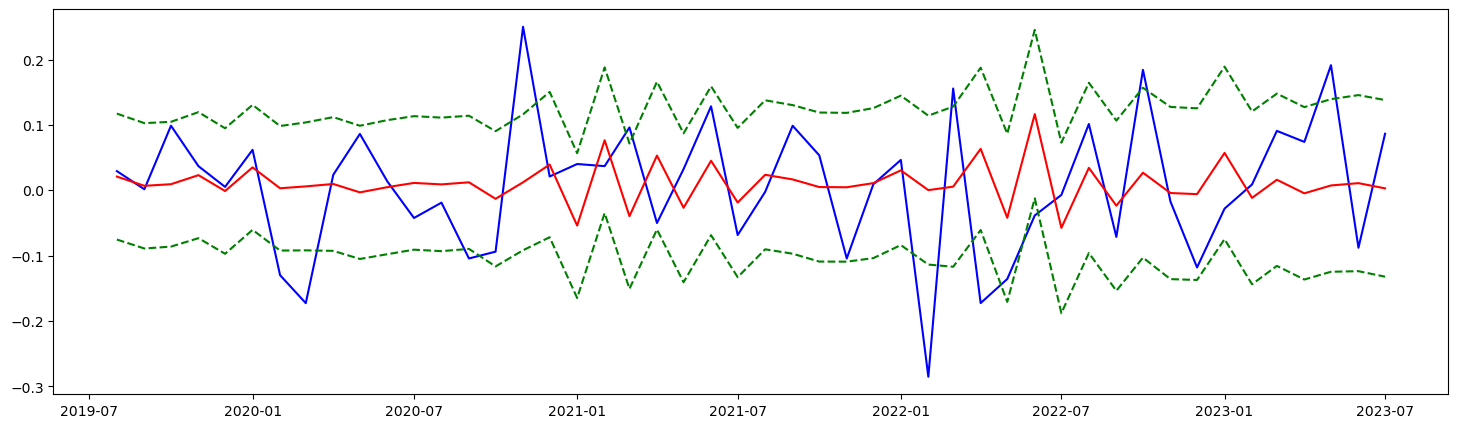

In [27]:
plt.rcParams["figure.figsize"] = 18, 5

plt.plot(test, color = "blue", label = "Тестовая выборка")

plt.plot(predictions, color = "red", label = "Прогноз")
plt.plot(upper_conf_int, color = "green", linestyle = "--", label = "Conidence Levels(95%)")
plt.plot(lower_conf_int, color = "green", linestyle = "--")


### ОЦЕНКА КАЧЕСТВА МОДЕЛИ

In [28]:
#Рассёт качества модели : MSE, MAE, Hit-Rate  

#MSE среднеквардратическая ошибка
test_score = mean_squared_error(test, predictions)
#MAE средняяабсолютная ошибка
mae = round(abs(test.values - predictions.values).mean(),10)
#Hit-Rate доля угаданных направлений
price_pred = pd.concat([test, predictions], axis=1)
price_pred.dropna(inplace=True)
price_pred.columns = ['Price', 'preds']
price_pred['hit'] = np.where(np.sign(price_pred['Price']) == np.sign(price_pred['preds']), 1, 0)
#Результирующее сообщение

print('MSE: %.5f' % test_score)
print(f'MAE is {mae}')
print(f"Hit rate: {round((price_pred['hit'].sum() / price_pred['hit'].count()) * 100,2)}%")

MSE: 0.01107
MAE is 0.0829844055
Hit rate: 58.33%


# МОДЕЛЬ , РАБОТАЮЩАЯ ЦИКЛОМ С ИЗМЕНЯЮЩИМЕСЯ ПАРАМЕТРАМИ

In [20]:
company_df = df.loc[df['TICKER'] == 'ЛУКОЙЛ']
#company_df['earn'] = (company_df.CLOSE-company_df.CLOSE.shift(1).fillna(0))/company_df.CLOSE.shift(1).fillna(0)
company_df['earn'] = company_df.CLOSE.pct_change()
#company_df.replace([np.inf, -np.inf], 100, inplace=True)
#company_df = company_df.loc[company_df.earn != 100]
series = company_df[['DATE','earn']].set_index('DATE')

In [21]:
#Делаем train и test выборки
historic = series.earn.iloc[:int(len(series) * 0.7)].to_list()
test = series.earn.iloc[int(len(series) * 0.7):]

In [6]:
upper_conf_int = []
lower_conf_int = []
predictions = []
for i in range(len(test)):
    res = statsmodels.tsa.stattools.arma_order_select_ic(historic, ic=["aic", "bic"])
    model = ARIMA(historic, order=(res.aic_min_order[0] , 0 , res.aic_min_order[1]) )
    model_results = model.fit()
    arma_forecast = model_results.get_forecast(1)
    arma_predictions_df = arma_forecast.conf_int(alpha = 0.05)
    pred = model_results.predict(start=len(historic), end=len(historic), dynamic=False)
    predictions.append(pred[0])
    upper_conf_int.append(arma_predictions_df[0][1])
    lower_conf_int.append(arma_predictions_df[0][0])
    historic.append(test[i])
predictions = pd.DataFrame(predictions).set_index(test.index)
upper_conf_int = pd.DataFrame(upper_conf_int).set_index(test.index)   
lower_conf_int = pd.DataFrame(lower_conf_int).set_index(test.index)  

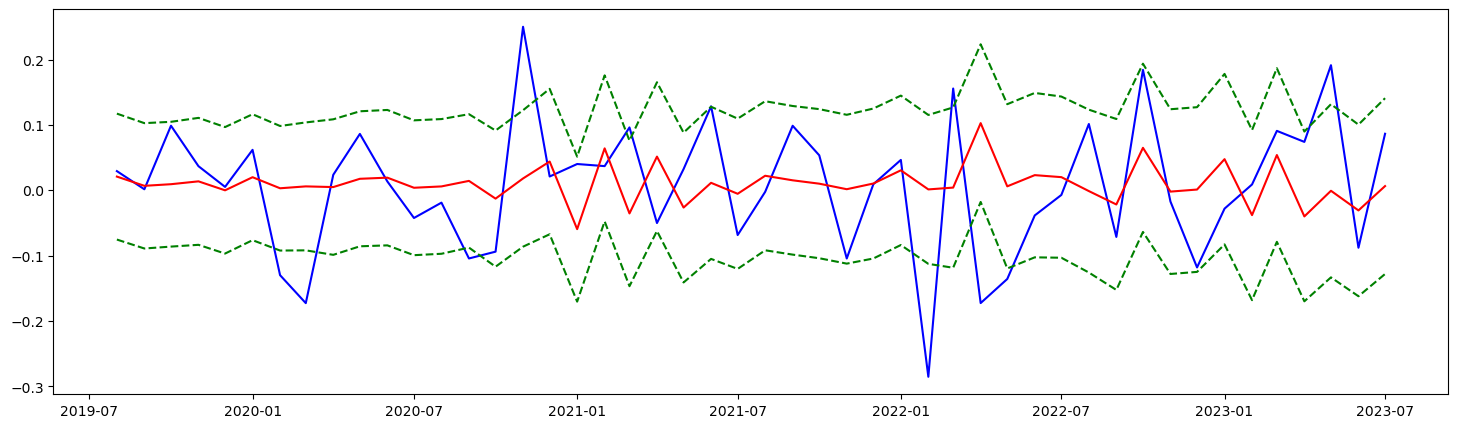

In [7]:
plt.rcParams["figure.figsize"] = 18, 5

plt.plot(test, color = "blue", label = "Тестовая выборка")

plt.plot(predictions, color = "red", label = "Прогноз")
plt.plot(upper_conf_int, color = "green", linestyle = "--", label = "Conidence Levels(95%)")
plt.plot(lower_conf_int, color = "green", linestyle = "--")


### ОЦЕНКА КАЧЕСТВА МОДЕЛИ

In [8]:
#Рассёт качества модели : MSE, MAE, Hit-Rate  

#MSE среднеквардратическая ошибка
test_score = mean_squared_error(test, predictions)
#MAE средняяабсолютная ошибка
mae = round(abs(test.values - predictions.values).mean(),10)
#Hit-Rate доля угаданных направлений
price_pred = pd.concat([test, predictions], axis=1)
price_pred.dropna(inplace=True)
price_pred.columns = ['Price', 'preds']
price_pred['hit'] = np.where(np.sign(price_pred['Price']) == np.sign(price_pred['preds']), 1, 0)
#Результирующее сообщение

print('MSE: %.5f' % test_score)
print(f'MAE is {mae}')
print(f"Hit rate: {round((price_pred['hit'].sum() / price_pred['hit'].count()) * 100,2)}%")

MSE: 0.01124
MAE is 0.0823680719
Hit rate: 52.08%


# ПОПЫТКА ПРОГНОЗИРОВАТЬ ОШИБКУ МОДЕЛЬЮ ARMA



In [19]:
company_df = df.loc[df['TICKER'] == 'ЛУКОЙЛ']
#company_df['earn'] = (company_df.CLOSE-company_df.CLOSE.shift(1).fillna(0))/company_df.CLOSE.shift(1).fillna(0)
company_df['earn'] = company_df.CLOSE.pct_change()
#company_df.replace([np.inf, -np.inf], 100, inplace=True)
#company_df = company_df.loc[company_df.earn != 100]
series = company_df[['DATE','earn']].set_index('DATE')

In [20]:
#Делаем train и test выборки
historic = series.earn.iloc[:int(len(series) * 0.7)].to_list()
test = series.earn.iloc[int(len(series) * 0.7):]

In [21]:
upper_conf_int = []
lower_conf_int = []
predictions = []
for i in range(len(test)):
    #Подбираем параметры под прогноз доходности и прогнозируем ее
    res = statsmodels.tsa.stattools.arma_order_select_ic(historic, ic=["aic", "bic"])
    model = ARIMA(historic, order=(res.aic_min_order[0] , 0 , res.aic_min_order[1]) )
    model_results = model.fit()
    pred = model_results.predict(start=len(historic), end=len(historic), dynamic=False)
    #Подбираем параметры под прогноз остатка и прогнозируем остаток и его ДИ
    resid_res = statsmodels.tsa.stattools.arma_order_select_ic(model_results.resid[1:], ic=["aic", "bic"])
    resid_model = ARIMA(model_results.resid[1:], order=(resid_res.aic_min_order[0] , 0 , resid_res.aic_min_order[1]) )
    resid_model_results = resid_model.fit()
    resid_forecast = resid_model_results.get_forecast(1)
    resid_conf_int = resid_forecast.conf_int(alpha = 0.05)
    #resid_pred = resid_model_results.predict(start=len(historic), end=len(historic), dynamic=False)
    #Пополняем списки прогнозом и его ДИ
    predictions.append(pred[0])
    upper_conf_int.append( pred[0] + resid_conf_int[0][1] )
    lower_conf_int.append( pred[0] + resid_conf_int[0][0] )
    
    historic.append(test[i])
predictions = pd.DataFrame(predictions).set_index(test.index)
upper_conf_int = pd.DataFrame(upper_conf_int).set_index(test.index)   
lower_conf_int = pd.DataFrame(lower_conf_int).set_index(test.index)  

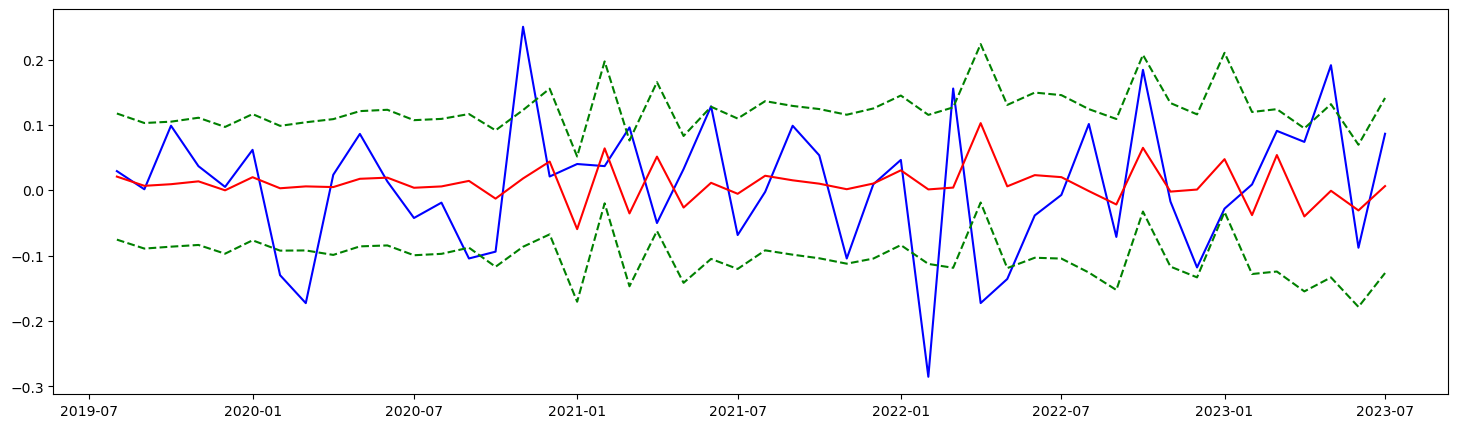

In [22]:
plt.rcParams["figure.figsize"] = 18, 5

plt.plot(test, color = "blue", label = "Тестовая выборка")

plt.plot(predictions, color = "red", label = "Прогноз")
plt.plot(upper_conf_int, color = "green", linestyle = "--", label = "Conidence Levels(95%)")
plt.plot(lower_conf_int, color = "green", linestyle = "--")

# ОБЩАЯ ПРОВЕРКА ВСЕХ КОМПАНИЙ НА ЦИКЛИЧЕСКОЕ ПРОГНОЗИРОВАНИЕ С МЕНЯЮЩИМЕСЯ ПАРАМЕТРАМИ

In [4]:
for j in companies:
    #Создаём дф и временной ряд доходностей
    company_df = df.loc[df['TICKER'] == j]
    company_df['earn'] = company_df.CLOSE.pct_change()
    series = company_df[['DATE','earn']].set_index('DATE')
#==============================Проверяем модель на параметрах BIC============================
    #Делаем train и test выборки
    historic = series.earn.iloc[:int(len(series) * 0.7)].to_list()
    test = series.earn.iloc[int(len(series) * 0.7):]

    upper_conf_int = []
    lower_conf_int = []
    predictions = []
    for i in range(len(test)):
        res = statsmodels.tsa.stattools.arma_order_select_ic(historic, ic=["aic", "bic"])
        model = ARIMA(historic, order=(res.bic_min_order[0] , 0 , res.bic_min_order[1]) )
        model_results = model.fit()
        arma_forecast = model_results.get_forecast(1)
        arma_predictions_df = arma_forecast.conf_int(alpha = 0.05)
        pred = model_results.predict(start=len(historic), end=len(historic), dynamic=False)
        predictions.append(pred[0])
        upper_conf_int.append(arma_predictions_df[0][1])
        lower_conf_int.append(arma_predictions_df[0][0])
        historic.append(test[i])
    predictions = pd.DataFrame(predictions).set_index(test.index)
    upper_conf_int = pd.DataFrame(upper_conf_int).set_index(test.index)   
    lower_conf_int = pd.DataFrame(lower_conf_int).set_index(test.index)          
    
    
    #Рассёт качества модели : MSE, MAE, Hit-Rate  

    #MSE среднеквардратическая ошибка
    test_score = mean_squared_error(test, predictions)
    #MAE средняяабсолютная ошибка
    mae = round(abs(test.values - predictions.values).mean(),10)
    #Hit-Rate доля угаданных направлений
    price_pred = pd.concat([test, predictions], axis=1)
    price_pred.dropna(inplace=True)
    price_pred.columns = ['Price', 'preds']
    price_pred['hit'] = np.where(np.sign(price_pred['Price']) == np.sign(price_pred['preds']), 1, 0)
    #Результирующее сообщение
    print("Актив {} , Параметры BIC".format(j))
    print('MSE: %.5f' % test_score)
    print(f'MAE is {mae}')
    print(f"Hit rate: {round((price_pred['hit'].sum() / price_pred['hit'].count()) * 100,2)}%\n")
    
    
#==============================Проверяем модель на параметрах AIC============================
    #Делаем train и test выборки
    historic = series.earn.iloc[:int(len(series) * 0.7)].to_list()
    test = series.earn.iloc[int(len(series) * 0.7):]

    upper_conf_int = []
    lower_conf_int = []
    predictions = []
    for i in range(len(test)):
        res = statsmodels.tsa.stattools.arma_order_select_ic(historic, ic=["aic", "bic"])
        model = ARIMA(historic, order=(res.aic_min_order[0] , 0 , res.aic_min_order[1]) )
        model_results = model.fit()
        arma_forecast = model_results.get_forecast(1)
        arma_predictions_df = arma_forecast.conf_int(alpha = 0.05)
        pred = model_results.predict(start=len(historic), end=len(historic), dynamic=False)
        predictions.append(pred[0])
        upper_conf_int.append(arma_predictions_df[0][1])
        lower_conf_int.append(arma_predictions_df[0][0])
        historic.append(test[i])
    predictions = pd.DataFrame(predictions).set_index(test.index)
    upper_conf_int = pd.DataFrame(upper_conf_int).set_index(test.index)   
    lower_conf_int = pd.DataFrame(lower_conf_int).set_index(test.index)          
    
    
    #Рассёт качества модели : MSE, MAE, Hit-Rate  

    #MSE среднеквардратическая ошибка
    test_score = mean_squared_error(test, predictions)
    #MAE средняяабсолютная ошибка
    mae = round(abs(test.values - predictions.values).mean(),10)
    #Hit-Rate доля угаданных направлений
    price_pred = pd.concat([test, predictions], axis=1)
    price_pred.dropna(inplace=True)
    price_pred.columns = ['Price', 'preds']
    price_pred['hit'] = np.where(np.sign(price_pred['Price']) == np.sign(price_pred['preds']), 1, 0)
    #Результирующее сообщение
    print("Актив {} , Параметры AIC".format(j))
    print('MSE: %.5f' % test_score)
    print(f'MAE is {mae}')
    print(f"Hit rate: {round((price_pred['hit'].sum() / price_pred['hit'].count()) * 100,2)}%\n")
    print('============')

Актив ГАЗПРОМ ао , Параметры BIC
MSE: 0.01348
MAE is 0.0825966856
Hit rate: 43.75%

Актив ГАЗПРОМ ао , Параметры AIC
MSE: 0.01365
MAE is 0.084892854
Hit rate: 47.92%

Актив Сбербанк , Параметры BIC
MSE: 0.01386
MAE is 0.0762967129
Hit rate: 64.58%

Актив Сбербанк , Параметры AIC
MSE: 0.01404
MAE is 0.078170265
Hit rate: 62.5%

Актив ЛУКОЙЛ , Параметры BIC
MSE: 0.01047
MAE is 0.078830152
Hit rate: 60.42%

Актив ЛУКОЙЛ , Параметры AIC
MSE: 0.01124
MAE is 0.0823680719
Hit rate: 52.08%

Актив ГМКНорНик , Параметры BIC
MSE: 0.00597
MAE is 0.0605331677
Hit rate: 56.25%

Актив ГМКНорНик , Параметры AIC
MSE: 0.00581
MAE is 0.0611318435
Hit rate: 58.33%

Актив Магнит ао , Параметры BIC
MSE: 0.01221
MAE is 0.0841032849
Hit rate: 60.42%

Актив Магнит ао , Параметры AIC
MSE: 0.01298
MAE is 0.0865139763
Hit rate: 56.25%

Актив Татнфт 3ао , Параметры BIC
MSE: 0.01066
MAE is 0.0791147585
Hit rate: 43.75%

Актив Татнфт 3ао , Параметры AIC
MSE: 0.01075
MAE is 0.0809581287
Hit rate: 45.83%

Актив Новатэ